In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")

    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/wgan")

    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [6]:
import numpy as np
import sklearn.datasets
import time
import random

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

import os, sys
import glob

In [ ]:
def prepare_swissroll_data(BATCH_SIZE=1000):
    data = sklearn.datasets.make_swiss_roll(
                    n_samples=BATCH_SIZE,
                    noise=0.25
                )[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 7.5 # stdev plus a little
    return data

def prepare_25gaussian_data(BATCH_SIZE=1000):
    dataset = []
    for i in range(BATCH_SIZE//25):
        for x in range(-2, 3):
            for y in range(-2, 3):
                point = np.random.randn(2)*0.05
                point[0] += 2*x
                point[1] += 2*y
                dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)
    np.random.shuffle(dataset)
    dataset /= 2.828 # stdev
    return dataset

def prepare_gaussians(num_samples_in_cluster, dim,
                      num_gaussian_per_dim, coord_limits,
                      std = 0.1, random_state = 42,
                      scale = 2.828):
    num_clusters = num_gaussian_per_dim ** dim
    num_samples = num_samples_in_cluster * num_clusters
    coords_per_dim = np.linspace(-coord_limits,
                                 coord_limits,
                                 num = num_gaussian_per_dim)
    copy_coords = list(np.tile(coords_per_dim, (dim, 1)))
    centers = np.array(np.meshgrid(*copy_coords)).T.reshape(-1, dim)
    dataset = sklearn.datasets.make_blobs(n_samples = num_samples,
                                          n_features = dim,
                                          centers = centers,
                                          cluster_std = std,
                                          random_state = random_state)[0]
    dataset /= scale
    return dataset

def prepare_train_batches(dataset, BATCH_SIZE):
    while True:
        for i in range(len(dataset) // BATCH_SIZE):
            yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]


In [ ]:
class Generator_2d(nn.Module):
    def __init__(self,
                 n_dim = 2,
                 n_hidden = 256,
                 device = device_default,
                 non_linear = nn.ReLU()):
        super(Generator_2d, self).__init__()
        self.non_linear = non_linear
        self.device = device
        self.n_hidden = n_hidden
        self.n_dim = n_dim
        self.layers = nn.ModuleList([nn.Linear(self.n_dim, self.n_hidden),
                                     nn.Linear(self.n_hidden, self.n_hidden),
                                     nn.Linear(self.n_hidden, self.n_hidden),
                                     nn.Linear(self.n_hidden, 2)])
        self.num_layer = len(self.layers)
        #for i in range(4):
        #    std_init = 0.8 * (2/self.layers[i].in_features)**0.5
        #    torch.nn.init.normal_(self.layers[i].weight, std = std_init)

    def make_hidden(self, batch_size):
        return torch.randn(batch_size, self.n_dim, device = self.device)

    def forward(self, z):
        for i in range(self.num_layer - 1):
            z = self.non_linear((self.layers[i])(z))
        z = (self.layers[self.num_layer - 1])(z)
        return z

    def sampling(self, batch_size):
        z = self.make_hidden(batch_size)
        #print(z.detach().cpu())
        return self.forward(z)

class Discriminator_2d(nn.Module):
    def __init__(self,
                 n_hidden = 512,
                 device = device_default,
                 non_linear = nn.ReLU()):
        super(Discriminator_2d, self).__init__()
        self.non_linear = non_linear
        self.device = device
        self.n_hidden = n_hidden
        self.layers = nn.ModuleList([nn.Linear(2, self.n_hidden),
                                     nn.Linear(self.n_hidden, self.n_hidden),
                                     nn.Linear(self.n_hidden, self.n_hidden),
                                     nn.Linear(self.n_hidden, 1)])
        self.num_layer = len(self.layers)
        #for i in range(4):
        #    std_init = 0.8 * (2/self.layers[i].in_features)**0.5
        #    torch.nn.init.normal_(self.layers[i].weight, std = std_init)

    def forward(self, z):
        for i in range(self.num_layer - 1):
            z = self.non_linear((self.layers[i])(z))
        z = (self.layers[self.num_layer - 1])(z)
        return z

In [7]:
X_train = prepare_25gaussian_data(BATCH_SIZE=1000)

<ipython-input-8-cc927450408c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


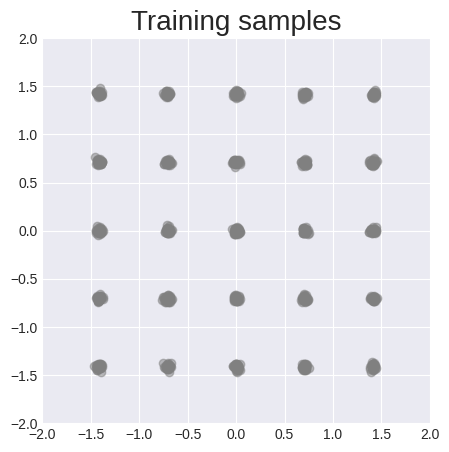

In [8]:
xmin = -2
xmax = 2
ymin = -2
ymax = 2
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(5, 5))


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Training samples", fontsize=20)
plt.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray', marker='o')
plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
def train_wgan(X_train,
               X_train_batches,
               generator, g_optimizer,
               discriminator, d_optimizer,
              #  path_to_save,
               batch_size = 256,
               device = device,
               use_gradient_penalty = True,
               Lambda = 0.1,
               num_epochs = 20000,
               num_epoch_for_save = 100,
               batch_size_sample = 5000,
               proj_list = None):

    k_g = 1
    generator_loss_arr = []
    generator_mean_loss_arr = []
    discriminator_loss_arr = []
    discriminator_mean_loss_arr = []
    one = torch.tensor(1, dtype = torch.float).to(device)
    mone = one * -1
    mone = mone.to(device)
    # path_to_save_models = os.path.join(path_to_save, 'models')
    # path_to_save_plots = os.path.join(path_to_save, 'plots')

    try:
        for epoch in range(num_epochs):
            print(f"Start epoch = {epoch}")
            if epoch < 25:
                k_d = 100
            else:
                k_d = 10

            for p in discriminator.parameters():  # reset requires_grad
                p.requires_grad = True

            start_time = time.time()
            # Optimize D
            # discriminator.train(True)
            # generator.train(False)
            for _ in range(k_d):
                # Sample noise
                # real_data = sample_data_batch(batch_size,
                #                               X_train,
                #                               device)
                discriminator.zero_grad()
                real_data = next(X_train_batches)
                if (real_data.shape[0] != batch_size):
                   continue

                real_data = torch.Tensor(real_data)
                real_data = autograd.Variable(real_data).to(device)

                d_real_data = discriminator(real_data).mean()
                d_real_data.backward(mone)

                noise = generator.make_hidden(batch_size)
                #with torch.no_grad():
                noise = autograd.Variable(noise).to(device)
                #print(noise.size())
                fake_data = generator(noise)
                d_fake_data = discriminator(fake_data).mean()
                d_fake_data.backward(one)

                d_loss = d_fake_data - d_real_data
                #print("OK")
                if use_gradient_penalty:
                    gradient_penalty = calc_gradient_penalty(discriminator,
                                                             real_data.data,
                                                             fake_data.data,
                                                             batch_size,
                                                             Lambda)
                    gradient_penalty.backward()
                    d_loss += gradient_penalty
                d_optimizer.step()
                discriminator_loss_arr.append(d_loss.data.cpu().numpy())

            #discriminator.train(False)
            #generator.train(True)
            # Optimize G
            for p in discriminator.parameters():  # to avoid computation
                p.requires_grad = False

            for _ in range(k_g):
                g_optimizer.zero_grad()

                # Do an update
                noise = generator.make_hidden(batch_size)
                noise = autograd.Variable(noise).to(device)
                fake_data = generator(noise)

                generator_loss = discriminator(fake_data).mean()
                generator_loss.backward(mone)
                generator_loss = -generator_loss
                g_optimizer.step()
                generator_loss_arr.append(generator_loss.data.cpu().numpy())

            end_time = time.time()
            calc_time = end_time - start_time
            discriminator_mean_loss_arr.append(np.mean(discriminator_loss_arr[-k_d :]))
            generator_mean_loss_arr.append(np.mean(generator_loss_arr[-k_g :]))
            print("Epoch {} of {} took {:.3f}s".format(
                   epoch + 1, num_epochs, calc_time))
            print("Discriminator last mean loss: \t{:.6f}".format(
                   discriminator_mean_loss_arr[-1]))
            print("Generator last mean loss: \t{:.6f}".format(
                   generator_mean_loss_arr[-1]))
            # if epoch % num_epoch_for_save == 0:
              #  Visualize
              #  epoch_visualization(X_train, generator,
              #                      use_gradient_penalty,
              #                      discriminator_mean_loss_arr,
              #                      epoch, Lambda,
              #                      generator_mean_loss_arr,
              #                      path_to_save_plots,
              #                      batch_size_sample,
              #                      proj_list)
              #  cur_time = datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')

              #  discriminator_model_name = cur_time + '_discriminator.pth'
              #  generator_model_name = cur_time + '_generator.pth'

              #  path_to_discriminator = os.path.join(path_to_save_models, discriminator_model_name)
              #  path_to_generator = os.path.join(path_to_save_models, generator_model_name)

              #  torch.save(discriminator.state_dict(), path_to_discriminator)
              #  torch.save(generator.state_dict(), path_to_generator)

    except KeyboardInterrupt:
        pass

In [11]:
def calc_gradient_penalty(D, real_data, fake_data, batch_size, Lambda = 0.1,
                          device = device):
    #print(real_data.shape)
    #print(fake_data.shape)
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size()).to(device)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates,
                                     requires_grad = True)
    discriminator_interpolates = D(interpolates)
    ones = torch.ones(discriminator_interpolates.size()).to(device)
    gradients = autograd.grad(outputs = discriminator_interpolates,
                              inputs = interpolates,
                              grad_outputs = ones,
                              create_graph = True,
                              retain_graph = True,
                              only_inputs = True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1.0) ** 2).mean() * Lambda
    return gradient_penalty

In [13]:
n_dim = 2

G = Generator_2d(n_dim = n_dim).to(device)
D = Discriminator_2d().to(device)

lr_init = 1e-4
d_optimizer = torch.optim.Adam(D.parameters(), betas = (0.5, 0.9), lr = lr_init)
g_optimizer = torch.optim.Adam(G.parameters(), betas = (0.5, 0.9), lr = lr_init)

Lambda = 0.1
num_epochs = 5000
batch_size = 256

X_train_batches = prepare_train_batches(X_train, batch_size)

train_wgan(X_train,
           X_train_batches,
           G, g_optimizer,
           D, d_optimizer,
           num_epochs=num_epochs
           )

In [14]:
def sample_fake_data(generator, X_train, batch_size_sample=batch_size, n_dim=n_dim):
    fake_data = generator(torch.randn(batch_size_sample, n_dim).to(device)).detach().cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.xlim(-2., 2.)
    plt.ylim(-2., 2.)
    plt.title("Training and generated samples", fontsize=20)
    plt.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray',
                marker='o', label = 'training samples')
    plt.scatter(fake_data[:,:1], fake_data[:,1:], alpha=0.5, color='blue',
                marker='o', label = 'samples by G')
    plt.legend()
    plt.grid(True)
    # plt.show()

In [15]:
# torch.save(G, '/content/drive/My Drive/wgan/25Gauss_G_5000eps.pt')
# torch.save(D, '/content/drive/My Drive/wgan/25Gauss_D_5000eps.pt')

In [17]:
G = torch.load('/content/drive/My Drive/wgan/25Gauss_G_5000eps.pt')
D = torch.load('/content/drive/My Drive/wgan/25Gauss_D_5000eps.pt')

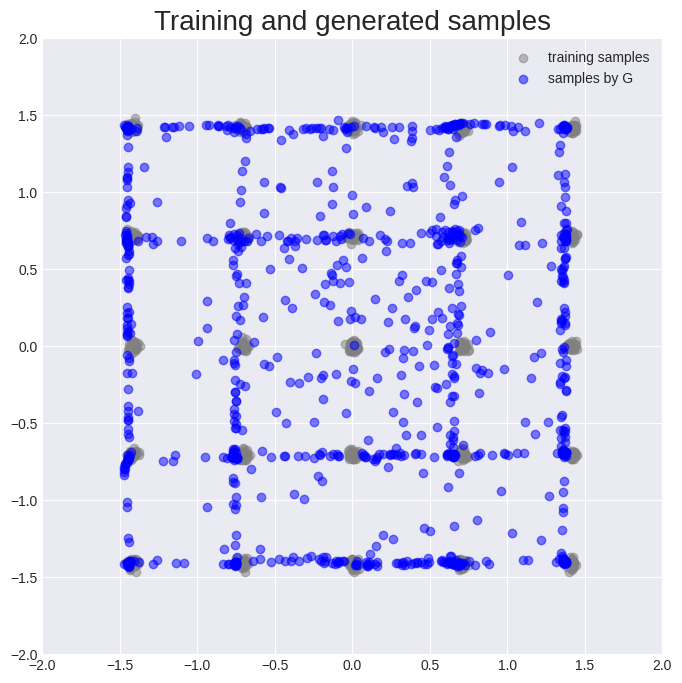

In [18]:
sample_fake_data(G, X_train, X_train.shape[0])

In [55]:
def Langevin_sampling(generator, discriminator,
                      z_dim, eps, num_iter, device):
    loc = torch.zeros(z_dim).to(device)
    scale = torch.ones(z_dim).to(device)
    normal = Normal(loc, scale)
    diagn = Independent(normal, 1)
    cur_z = diagn.sample()
    cur_z.requires_grad_(True)
    latent_arr = [cur_z.clone()]
    for i in range(num_iter - 1):
        GAN_part = -discriminator(generator(cur_z))
        latent_part = -diagn.log_prob(cur_z)
        energy = GAN_part + latent_part
        energy.backward()
        noise = diagn.sample()
        with torch.no_grad():
            cur_z -= (eps/2*cur_z.grad - (eps ** 0.5)*noise)
        latent_arr.append(cur_z.clone())
    latent_arr = torch.stack(latent_arr, dim = 0)
    return latent_arr

In [19]:
def MALA_sampling(generator, discriminator,
                  z_dim, eps, num_iter, device):
   loc = torch.zeros(z_dim).to(device)
   scale = torch.ones(z_dim).to(device)
   normal = Normal(loc, scale)
   diagn = Independent(normal, 1)
   uniform_sampler = Uniform(low = 0.0, high = 1.0)
   cur_z = diagn.sample()
   cur_z.requires_grad_(True)
   latent_arr = [cur_z.clone()]
   for i in range(num_iter):
      GAN_part = -discriminator(generator(cur_z))
      latent_part = -diagn.log_prob(cur_z)
      cur_energy = GAN_part + latent_part
      cur_energy.backward()
      noise = diagn.sample()
      gamma = eps/2
      with torch.no_grad():
         new_z = (cur_z - gamma*cur_z.grad + (eps ** 0.5)*noise)
      new_z = new_z.clone()
      new_z.requires_grad_(True)
      new_energy = -discriminator(generator(new_z)) - diagn.log_prob(new_z)
      new_energy.backward()
      energy_part = cur_energy - new_energy
      with torch.no_grad():
         vec_for_propose_2 = cur_z - new_z + gamma*new_z.grad
      propose_part_2 = (vec_for_propose_2 @ vec_for_propose_2)/4.0/gamma
      propose_part = (noise @ noise)/2.0 - propose_part_2
      log_accept_prob = propose_part + energy_part
      generate_uniform_var = uniform_sampler.sample().to(device)
      log_generate_uniform_var = torch.log(generate_uniform_var)
      if log_generate_uniform_var < log_accept_prob:
          latent_arr.append(new_z.clone())
          cur_z = new_z
          cur_z.grad.data.zero_()

   latent_arr = torch.stack(latent_arr, dim = 0)
   return latent_arr

In [21]:
# latent_arr_init = []
# latent_arr = []
# for i in range(1000):
#   if i % 10 == 0:
#     print(i)
#   res = MALA_sampling(G, D, n_dim, 1e-6, 1000, device)
#   latent_arr_init.append(res[0])
#   latent_arr.append(res[-1])
# latent_arr_init = torch.stack(latent_arr_init)
# latent_arr = torch.stack(latent_arr)

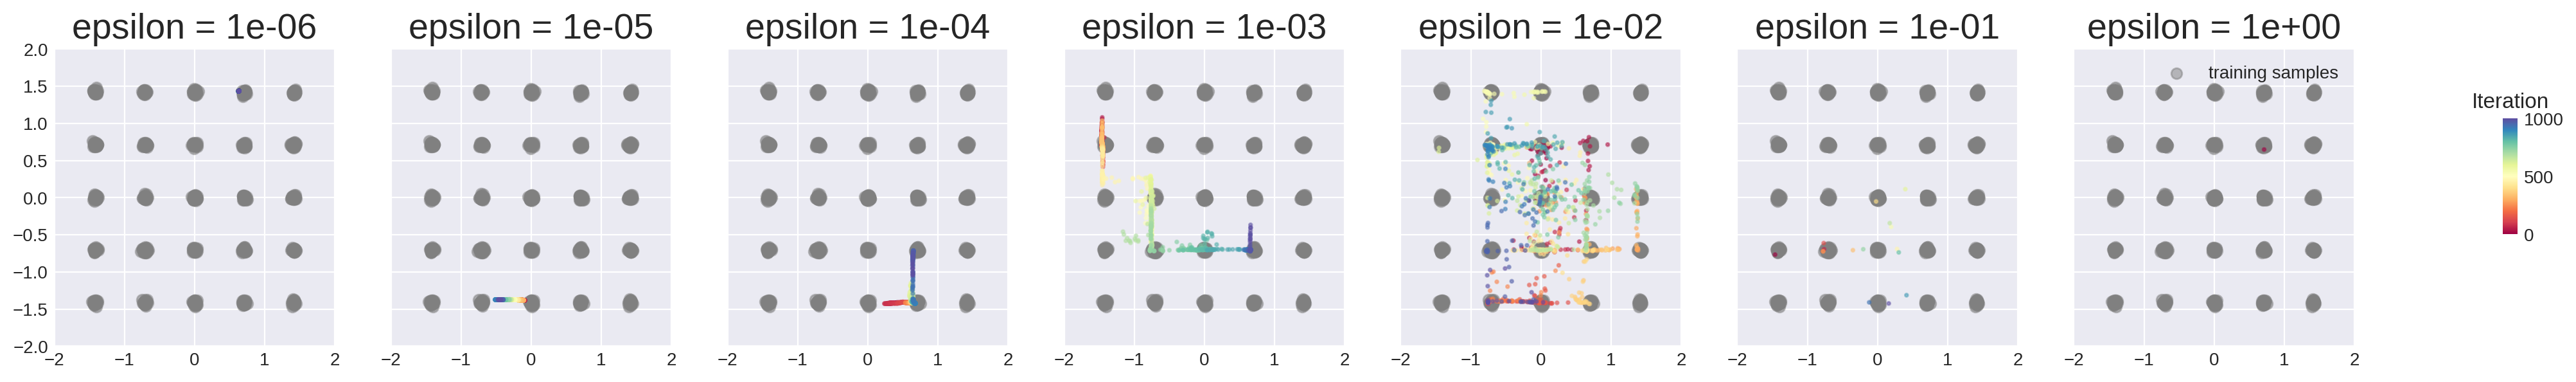

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=len(range(-6, 1)), figsize=(len(range(-6, 1))*3.3, 3), dpi=200, sharex=True, sharey=True)
for i, ax in zip(range(-6, 1), axes.ravel()):
  eps = 10**i
  latent_arr = MALA_sampling(G, D, n_dim, eps, 1000, device)

  ax.set_xlim(-2., 2.)
  ax.set_ylim(-2., 2.)
  ax.set_title(f"epsilon = {eps:.0e}", fontsize=20)
  ax.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray',
              marker='o', label = 'training samples')
  ax.grid(True)
  res = G(latent_arr).detach().cpu().numpy()
  ax.scatter(res[:, 0], res[:, 1], alpha=0.5, c=np.arange(len(res)), cmap='Spectral', s=3)

ax.legend()
# plt.suptitle('Training samples and latent space changes', y=1.1, font)

norm = plt.Normalize(0, 1000)
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.4, 0.005, 0.3])
cbar = ax.figure.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title('Iteration')
plt.show()

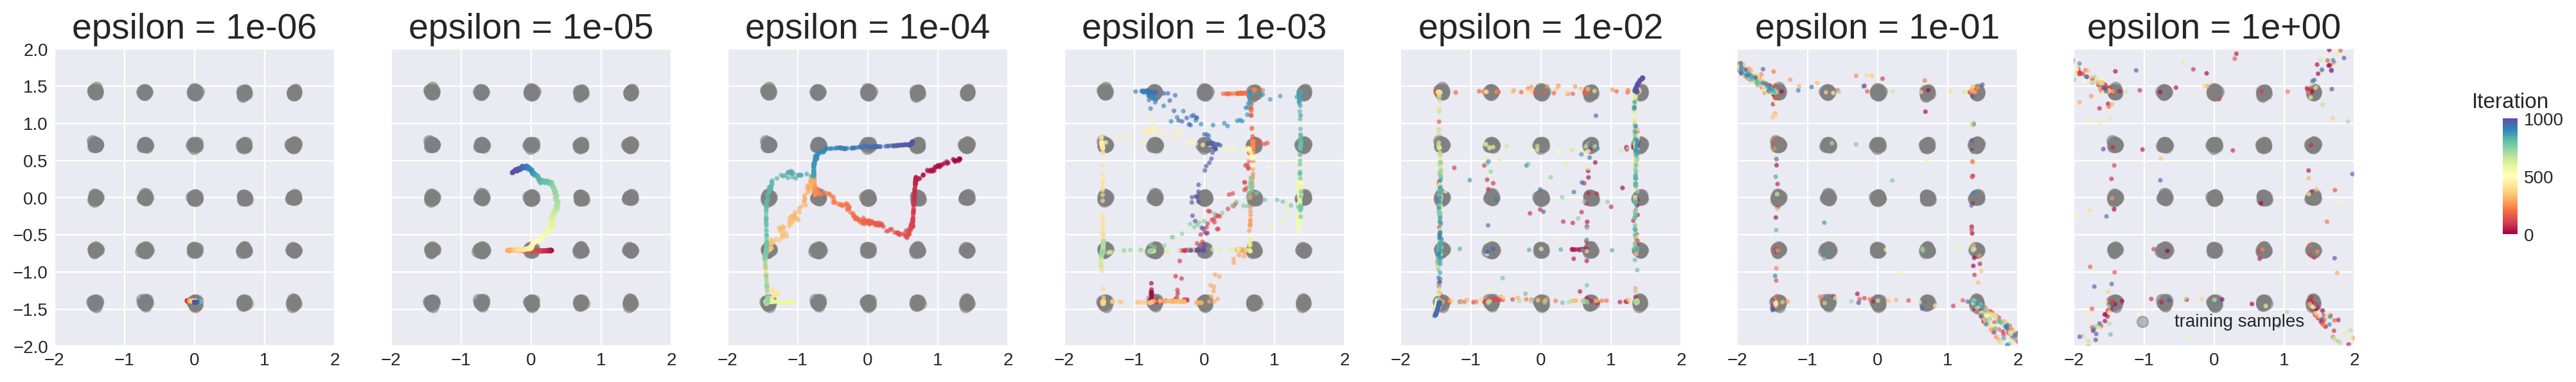

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=len(range(-6, 1)), figsize=(len(range(-6, 1))*3.3, 3), dpi=200, sharex=True, sharey=True)
for i, ax in zip(range(-6, 1), axes.ravel()):
  eps = 10**i
  latent_arr = Langevin_sampling(G, D, n_dim, eps, 1000, device)

  ax.set_xlim(-2., 2.)
  ax.set_ylim(-2., 2.)
  ax.set_title(f"epsilon = {eps:.0e}", fontsize=20)
  ax.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray',
              marker='o', label = 'training samples')
  ax.grid(True)
  res = G(latent_arr).detach().cpu().numpy()
  ax.scatter(res[:, 0], res[:, 1], alpha=0.5, c=np.arange(len(res)), cmap='Spectral', s=3)

ax.legend()
# plt.suptitle('Training samples and latent space changes', y=1.1, font)

norm = plt.Normalize(0, 1000)
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.4, 0.005, 0.3])
cbar = ax.figure.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title('Iteration')
plt.show()

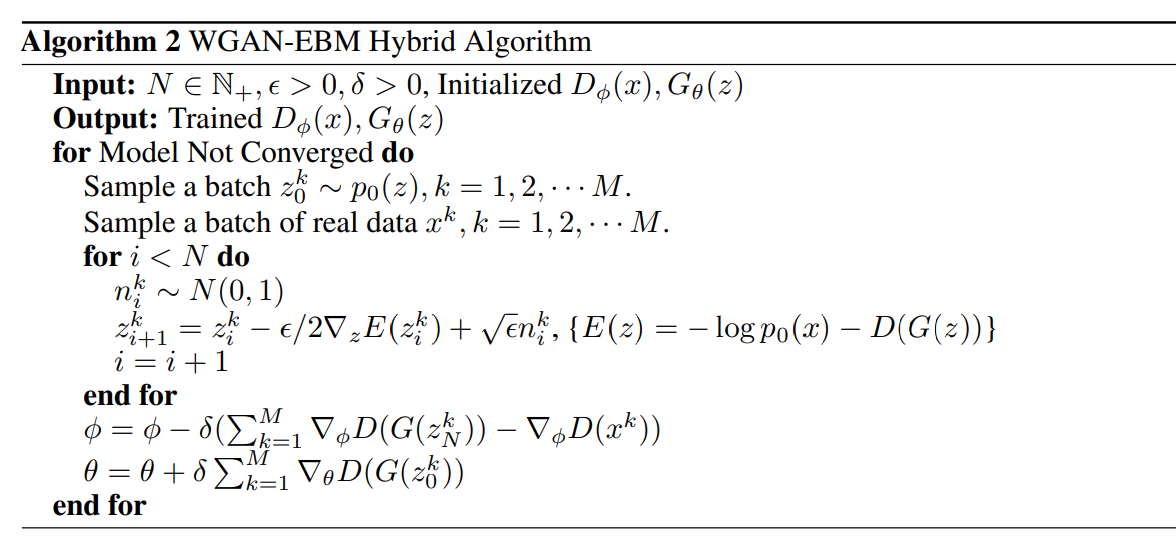

In [67]:
X_train = prepare_swissroll_data(5000)
X_train_batches = prepare_train_batches(X_train, batch_size)

In [68]:
n_dim = 2
G = Generator_2d(n_dim=n_dim).to(device)
D = Discriminator_2d().to(device)

d_optimizer = torch.optim.Adam(D.parameters(), betas = (0.5, 0.9), lr = lr_init)
g_optimizer = torch.optim.Adam(G.parameters(), betas = (0.5, 0.9), lr = lr_init)

In [ ]:
num_epochs = 5000

train_wgan(X_train,
           X_train_batches,
           G, g_optimizer,
           D, d_optimizer,
           num_epochs=num_epochs
           )

Выходные данные были обрезаны до нескольких последних строк (5000).
Start epoch = 3750
Epoch 3751 of 5000 took 0.064s
Discriminator last mean loss: 	-0.026567
Generator last mean loss: 	0.171271
Start epoch = 3751
Epoch 3752 of 5000 took 0.064s
Discriminator last mean loss: 	-0.011894
Generator last mean loss: 	0.201042
Start epoch = 3752
Epoch 3753 of 5000 took 0.066s
Discriminator last mean loss: 	-0.028974
Generator last mean loss: 	0.346131
Start epoch = 3753
Epoch 3754 of 5000 took 0.061s
Discriminator last mean loss: 	-0.042675
Generator last mean loss: 	0.298426
Start epoch = 3754
Epoch 3755 of 5000 took 0.065s
Discriminator last mean loss: 	-0.038344
Generator last mean loss: 	0.196439
Start epoch = 3755
Epoch 3756 of 5000 took 0.073s
Discriminator last mean loss: 	-0.025183
Generator last mean loss: 	0.113662
Start epoch = 3756
Epoch 3757 of 5000 took 0.062s
Discriminator last mean loss: 	-0.013253
Generator last mean loss: 	0.070335
Start epoch = 3757
Epoch 3758 of 5000 took 

In [69]:
G = torch.load('/content/drive/My Drive/wgan/Swiss_G_5000eps.pt')
D = torch.load('/content/drive/My Drive/wgan/Swiss_D_5000eps.pt')

In [70]:
# torch.save(G, '/content/drive/My Drive/wgan/Swiss_G_5000eps.pt')
# torch.save(D, '/content/drive/My Drive/wgan/Swiss_D_5000eps.pt')

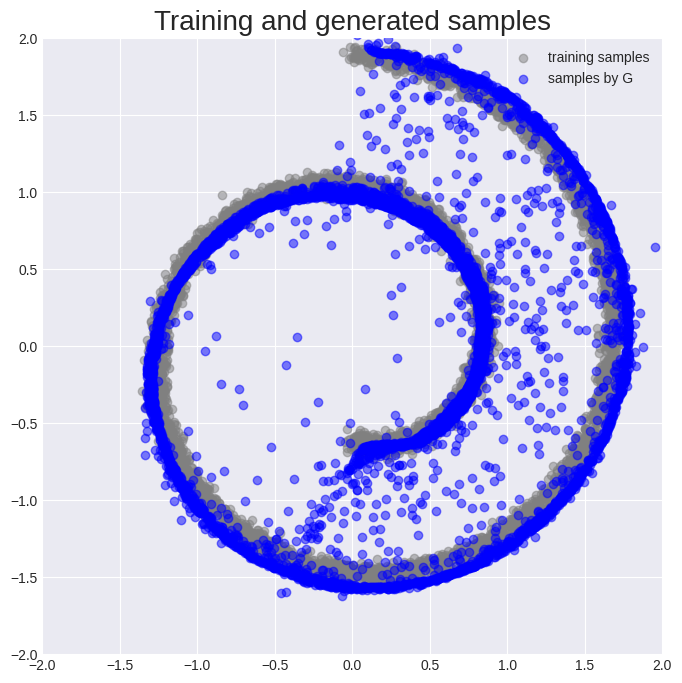

In [71]:
sample_fake_data(G, X_train, X_train.shape[0])

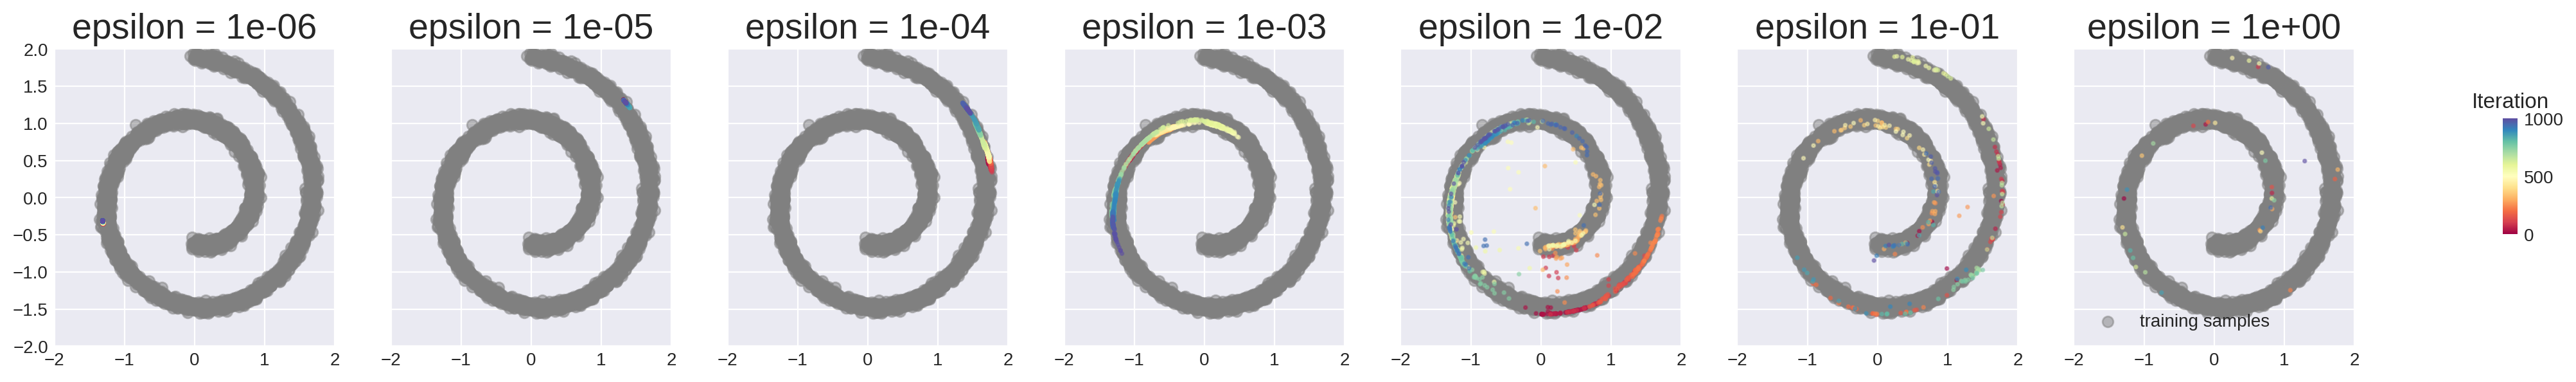

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=len(range(-6, 1)), figsize=(len(range(-6, 1))*3.3, 3), dpi=200, sharex=True, sharey=True)
for i, ax in zip(range(-6, 1), axes.ravel()):
  eps = 10**i
  latent_arr = MALA_sampling(G, D, n_dim, eps, 1000, device)

  ax.set_xlim(-2., 2.)
  ax.set_ylim(-2., 2.)
  ax.set_title(f"epsilon = {eps:.0e}", fontsize=20)
  ax.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray',
              marker='o', label = 'training samples')
  ax.grid(True)
  res = G(latent_arr).detach().cpu().numpy()
  ax.scatter(res[:, 0], res[:, 1], alpha=0.5, c=np.arange(len(res)), cmap='Spectral', s=3)

ax.legend()
# plt.suptitle('Training samples and latent space changes', y=1.1, font)

norm = plt.Normalize(0, 1000)
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.4, 0.005, 0.3])
cbar = ax.figure.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title('Iteration')
plt.show()

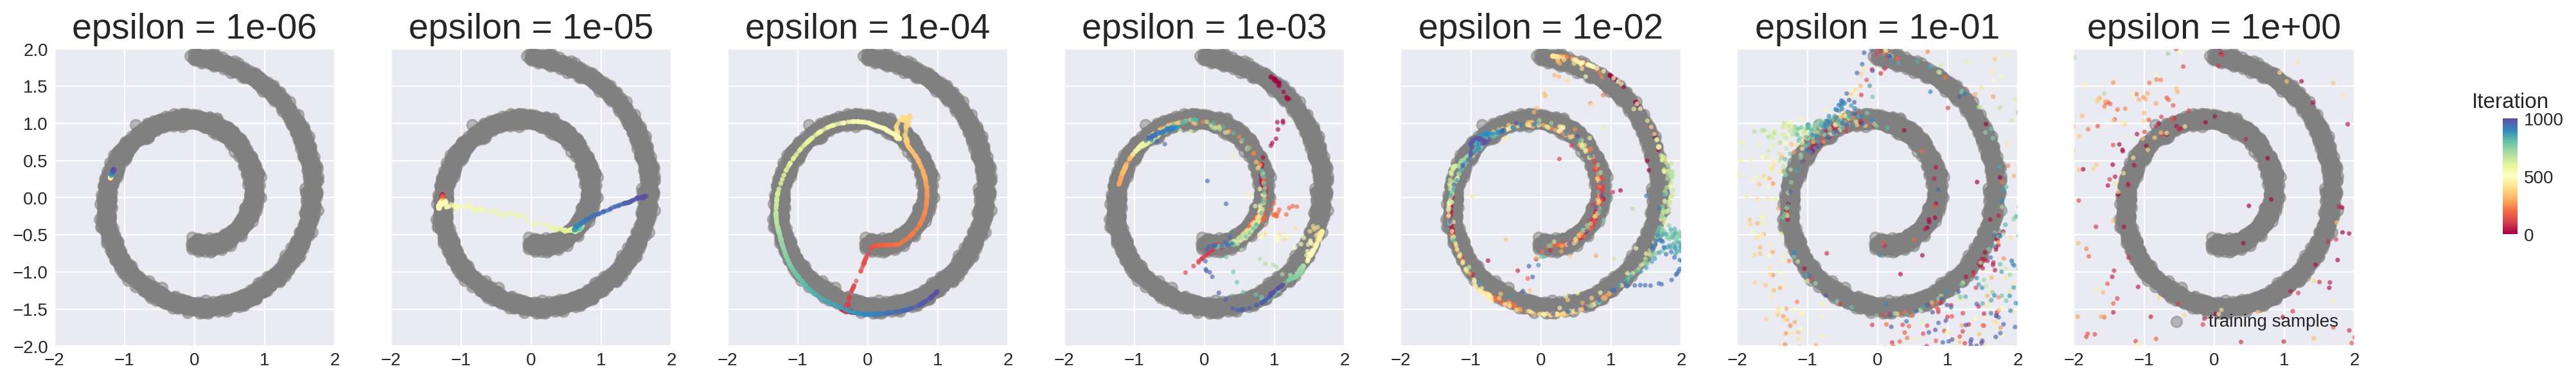

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=len(range(-6, 1)), figsize=(len(range(-6, 1))*3.3, 3), dpi=200, sharex=True, sharey=True)
for i, ax in zip(range(-6, 1), axes.ravel()):
  eps = 10**i
  latent_arr = Langevin_sampling(G, D, n_dim, eps, 1000, device)

  ax.set_xlim(-2., 2.)
  ax.set_ylim(-2., 2.)
  ax.set_title(f"epsilon = {eps:.0e}", fontsize=20)
  ax.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray',
              marker='o', label = 'training samples')
  ax.grid(True)
  res = G(latent_arr).detach().cpu().numpy()
  ax.scatter(res[:, 0], res[:, 1], alpha=0.5, c=np.arange(len(res)), cmap='Spectral', s=3)

ax.legend()
# plt.suptitle('Training samples and latent space changes', y=1.1, font)

norm = plt.Normalize(0, 1000)
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.4, 0.005, 0.3])
cbar = ax.figure.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title('Iteration')
plt.show()